# Quora Questions Pairs
- 데이터 : Quora Questions Pairs 
 https://www.kaggle.com/c/quora-question-pairs
- kaggle 가입 : https://www.kaggle.com/
- kgggle.json 다운로드 : `https://www.kaggle.com/<username>/account`

## 라이브러리 임포트

In [69]:
import os
import zipfile
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

## 구글 드라이브 마운트

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 저장 디렉토리 생성

In [71]:
DATA_PATH = '/content/drive/MyDrive/nlpdata/quora/'

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

## 데이터 파일 다운로드

In [72]:
! pip install -q kaggle

In [73]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"kgpark88","key":"fbaa5f23aa5ea9df8205d227ee58f7c1"}'}

In [74]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [75]:
! kaggle competitions download -c quora-question-pairs

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


## 다운로드 받은 파일 압축 풀기

In [76]:
zip_files = ['train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip']

for file in zip_files:
    zipRef = zipfile.ZipFile(file, 'r')
    zipRef.extractall(DATA_PATH)
    zipRef.close()

In [77]:
print("파일 크기 : ")
for file in os.listdir(DATA_PATH):
    print(f'{file: <20}  {os.path.getsize(DATA_PATH + file)/1000:,} MB')

파일 크기 : 
train.csv             63,399.11 MB
test.csv              477,592.983 MB
sample_submission.csv  22,346.871 MB
train_q1.npy          50,132.088 MB
train_q2.npy          50,132.088 MB
train_label.npy       3,234.448 MB
data_configs.json     1,776.582 MB
test_q1.npy           290,878.832 MB
test_q2.npy           290,878.832 MB
test_id.npy           11,602.627 MB
checkpoint            4.096 MB
quora_xgb.csv         43,364.119 MB


## 데이터 분석

In [78]:
train_data = pd.read_csv(DATA_PATH + 'train.csv')
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [79]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [80]:
for i in range(20):
    print(train_data['question1'][i])
    print(train_data['question2'][i])
    print(train_data['is_duplicate'][i])
    print('-'*100)

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?
0
----------------------------------------------------------------------------------------------------
What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
0
----------------------------------------------------------------------------------------------------
How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?
0
----------------------------------------------------------------------------------------------------
Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?
0
----------------------------------------------------------------------------------------------------
Which one dissolve in water quikly sugar, salt, methane and carbon di o

In [81]:
train_set = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str)
train_set.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [82]:
print(f'데이터 개수: {len(np.unique(train_set)):,}')
print(f'데이터 중복 개수: {np.sum(train_set.value_counts() > 1):,}')

데이터 개수: 537,361
데이터 중복 개수: 111,873


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


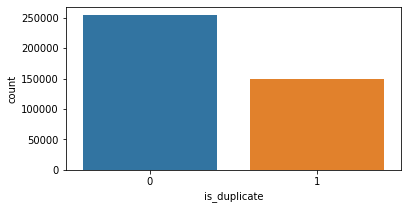

In [83]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['is_duplicate'])

In [84]:
train_length = train_set.apply(len)

In [85]:
print(f'질문 길이 최대 값: {np.max(train_length):,}')
print(f'질문 길이 평균 값: {np.mean(train_length):.2f}')
print(f'질문 길이 표준편차: {np.std(train_length):.2f}')
print(f'질문 길이 중간 값: {np.median(train_length)}')

질문 길이 최대 값: 1,169
질문 길이 평균 값: 59.82
질문 길이 표준편차: 31.96
질문 길이 중간 값: 51.0


In [86]:
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))

In [87]:
print(f'질문 단어 개수 최대 값: {np.max(train_word_counts)}')
print(f'질문 단어 개수 평균 값: {np.mean(train_word_counts):.2f}')
print(f'질문 단어 개수 표준편차: {np.std(train_word_counts):.2f}')
print(f'질문 단어 개수 중간 값: {np.median(train_word_counts)}')

질문 단어 개수 최대 값: 237
질문 단어 개수 평균 값: 11.06
질문 단어 개수 표준편차: 5.89
질문 단어 개수 중간 값: 10.0


## 데이터 전처리

In [88]:
import re
import json
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [89]:
DATA_PATH = '/content/drive/MyDrive/nlpdata/quora/'
FILTERS = "([~.,!?\"':;)(])"
MAX_SEQUENCE_LENGTH = 31

change_filter = re.compile(FILTERS)

In [90]:
train_data = pd.read_csv(DATA_PATH + 'train.csv', encoding='utf-8')

In [91]:
train_pos_data = train_data.loc[train_data['is_duplicate'] == 1]
train_neg_data = train_data.loc[train_data['is_duplicate'] == 0]

class_difference = len(train_neg_data) - len(train_pos_data)
sample_frac = 1 - (class_difference / len(train_neg_data))

train_neg_data = train_neg_data.sample(frac = sample_frac)

In [92]:
print("중복 질문 개수: {len(train_pos_data)}")
print("중복이 아닌 질문 개수: {len(train_neg_data)}")

중복 질문 개수: {len(train_pos_data)}
중복이 아닌 질문 개수: {len(train_neg_data)}


In [93]:
train_data = pd.concat([train_neg_data, train_pos_data])

In [94]:
change_filter = re.compile(FILTERS)

questions1 = [str(s) for s in train_data['question1']]
questions2 = [str(s) for s in train_data['question2']]

filtered_questions1 = list()
filtered_questions2 = list()

for q in questions1:
     filtered_questions1.append(re.sub(change_filter, "", q).lower())
        
for q in questions2:
     filtered_questions2.append(re.sub(change_filter, "", q).lower())

In [95]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_questions1 + filtered_questions2)

In [96]:
questions1_sequence = tokenizer.texts_to_sequences(filtered_questions1)
questions2_sequence = tokenizer.texts_to_sequences(filtered_questions2)

In [97]:
q1_data = pad_sequences(questions1_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
q2_data = pad_sequences(questions2_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [106]:
word_vocab = {}
word_vocab = tokenizer.word_index 

labels = np.array(train_data['is_duplicate'], dtype=int)

print(f'Shape of question1 data: {q1_data.shape}')
print(f'Shape of question2 data:{q2_data.shape}')
print(f'Shape of label: {labels.shape}')
print(f"Words in index: {len(word_vocab)}")

Shape of question1 data: (298526, 31)
Shape of question2 data:(298526, 31)
Shape of label: (298526,)
Words in index: 76516


In [99]:
data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)+1

In [100]:
TRAIN_Q1_DATA = 'train_q1.npy'
TRAIN_Q2_DATA = 'train_q2.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

np.save(open(DATA_PATH + TRAIN_Q1_DATA, 'wb'), q1_data)
np.save(open(DATA_PATH + TRAIN_Q2_DATA , 'wb'), q2_data)
np.save(open(DATA_PATH + TRAIN_LABEL_DATA , 'wb'), labels)

json.dump(data_configs, open(DATA_PATH + DATA_CONFIGS, 'w'))

In [101]:
test_data = pd.read_csv(DATA_PATH + 'test.csv', encoding='utf-8')
valid_ids = [type(x) ==int for x in test_data.test_id] 
test_data = test_data[valid_ids].drop_duplicates()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
test_questions1 = [str(s) for s in test_data['question1']]
test_questions2 = [str(s) for s in test_data['question2']]

filtered_test_questions1 = list()
filtered_test_questions2 = list()

for q in test_questions1:
     filtered_test_questions1.append(re.sub(change_filter, "", q).lower())
        
for q in test_questions2:
     filtered_test_questions2.append(re.sub(change_filter, "", q).lower())

In [103]:
test_questions1_sequence = tokenizer.texts_to_sequences(filtered_test_questions1)
test_questions2_sequence = tokenizer.texts_to_sequences(filtered_test_questions2)

test_q1_data = pad_sequences(test_questions1_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_q2_data = pad_sequences(test_questions2_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [104]:
test_id = np.array(test_data['test_id'])

print(f'Shape of question1 data: {test_q1_data.shape}')
print(f'Shape of question2 data:{test_q2_data}')
print(f'Shape of ids: {test_id}')

Shape of question1 data: (2345796, 31)
Shape of question2 data:[[  16   55 1038 ...    0    0    0]
 [   4   78  328 ...    0    0    0]
 [   2   15  680 ...    0    0    0]
 ...
 [  13    7  324 ...    0    0    0]
 [   2   11    1 ...    0    0    0]
 [   4    9    5 ...    0    0    0]]
Shape of ids: [0 1 2 ... 2345793 2345794 2345795]


In [105]:
TEST_Q1_DATA = 'test_q1.npy'
TEST_Q2_DATA = 'test_q2.npy'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_PATH + TEST_Q1_DATA, 'wb'), test_q1_data)
np.save(open(DATA_PATH + TEST_Q2_DATA , 'wb'), test_q2_data)
np.save(open(DATA_PATH + TEST_ID_DATA , 'wb'), test_id)